# Razlaga izraznih kart dokumentov

Dimenzionalnost vektorskih predstavitev dokumentov lahko zmanjšamo na 2, kar nam omogoča prikaz dvodimenzionalne karte dokumentov, na kateri vsaka točka predstavlja dokument. Poleg tega lahko v dvodimenzionalnem prostoru odkrijemo skupine podobnih dokumentov in vsako skupino na karti obarvamo z različno barvo. To nam omogoča dober vpogled v celotno množico dokumentov.

V tem zvezku bomo skupine označili s ključnimi besedami, kar razloži skupno tematiko dokumentov v skupini. Za pripis ključnih besed smo pripravili več metod, zato bomo pokazali razlago izraznih kar s štirimi različnimi metodami.

In [1]:
from collections import Counter

from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_SLOVENE
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
import seaborn as sns
from umap import UMAP
import numpy as np
import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from textsemantics.server_api import ServerAPI
from textsemantics import specific_words

Za začetek si preko API-ja pridobimo besedila zadnjih 100 predlogov vladi, ki vsebujejo vsaj 50 znakov ter iz datoteke preberemo fastText vektorje iz prejšnjega primera.

In [2]:
nltk.download('stopwords', quiet=True)

api = ServerAPI()
metadata = api.get_metadata('predlogi-vladi', sample_size=100, sampling_strategy='latest')

texts = api.get_texts(urls=metadata['text'])
texts = [text for text in texts if len(text) > 50]

def preprocess(corpus):
    stop_words = set(stopwords.words('slovene'))
    tokenizer = RegexpTokenizer("\w+")
    lemmatizer = Lemmatizer(dictionary=DICTIONARY_SLOVENE)
    
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]
        preprocessed.append(tokens)
        
    return preprocessed

tokens_list = preprocess(texts)

ft = np.load('data/ft.npy')

Iz vsakega od besedil izluščimo ključne besede s štirimi različnimi metodami:
- TF-IDF
- YAKE!
- Metoda na podlagi vektorskih vložitev
- TextRank

In [3]:
tfidf_kw = specific_words.tfidf_keywords(tokens=tokens_list)
yake_kw = specific_words.yake_keywords(texts)
emb_document_kw = specific_words.embedding_document_keywords(tokens=tokens_list)
text_rank_kw = specific_words.text_rank_keywords(tokens=tokens_list)

methods_keywords = [
    ("TF-IDF", tfidf_kw),
    ("YAKE!", yake_kw),
    ("Vložitve - dokumenti", emb_document_kw),
    ("TextRank", text_rank_kw),
]

Dokumente vložimo v dvodimenzionalni prostor, poiščemo skupine ter vsako skupino opišemo s specifičnimi besedami. Vzamemo tiste specifične besede, ki se najbolj pogosto pojavijo pri dokumentih v skupini.

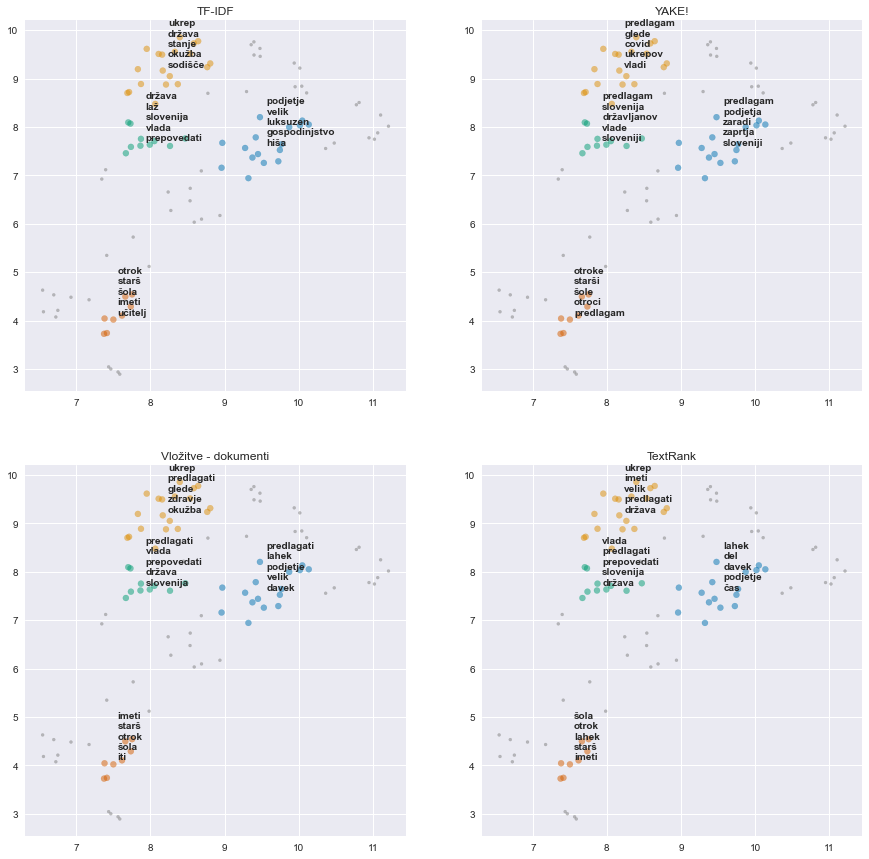

In [4]:
def plot_graph(points, labels):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    palette = sns.color_palette('colorblind', n_clusters)
    
    cs = [palette[l] if l > -1 else (0.5, 0.5, 0.5) for l in labels]
    s = [36 if l > -1 else 9 for l in labels]
    plt.scatter(points[:, 0], points[:, 1], c=cs, alpha=0.5, s=s)
    
    
def annoate_graph(points, labels, keywords):
    num_kw = 15
    for cluster in set(labels) - {-1}:
        cluster_idx = np.where(labels == cluster)[0]
        centroid = np.mean(points[cluster_idx, :], axis=0)
    
        clis = set(cluster_idx)
        all_kws = [kw for i, kws in enumerate(keywords) if i in clis for kw, _ in kws[:num_kw]]
        c =Counter(all_kws).most_common(5)

        ann = "\n".join(w for w, _ in c)
        plt.text(centroid[0], centroid[1], ann, fontdict={'fontweight': 'bold'})
    

plt.style.use('seaborn')
plt.figure(figsize=(15,15))

umap = UMAP(n_neighbors=5, min_dist=0.0, metric='cosine', random_state=0).fit(ft)
dbscan = DBSCAN(min_samples=8).fit(umap.embedding_)

for i, (method, kws) in enumerate(methods_keywords):
    plt.subplot(2, 2, i + 1)
    plt.title(method)
    plot_graph(umap.embedding_, dbscan.labels_)
    annoate_graph(umap.embedding_, dbscan.labels_, kws);